In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import optuna


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
posts = pd.read_csv('/kaggle/input/alldatafiltered/AllDataFiltered.csv')
posts.head(5)

,combined_text,link_flair_text
0,"for everyone, whether you're worried about cov...",psa
1,and people wonder why the virus spreads…,rant
2,r/udub mods,meme
3,thoughts on madrona? i have an emotional suppo...,discussion
4,soc 222 anyone has took or taking soc222(socio...,academics


In [4]:
def clean_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

posts['tokens'] = posts['combined_text'].apply(clean_tokenize)

In [4]:
results = []

In [5]:
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)

texts_bow = count_vectorizer.fit_transform(posts['tokens'])

X_train_bow, X_test_bow, y_train, y_test = train_test_split(texts_bow, posts['link_flair_text'], test_size=0.2, random_state=52)

bow_lr = LogisticRegression(max_iter=1000)
bow_lr.fit(X_train_bow, y_train)

y_pred_bow = bow_lr.predict(X_test_bow)

accuracy_bow = accuracy_score(y_test, y_pred_bow)

results.append({'vectorizationType': 'Bag of Words (BoW)', 'Model': 'LogisticRegression', 'Accuracy': accuracy_bow * 100})

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(


In [6]:
bow_svc = SVC()
bow_svc.fit(X_train_bow, y_train)

y_pred_bow = bow_svc.predict(X_test_bow)

accuracy_bow = accuracy_score(y_test, y_pred_bow)

results.append({'vectorizationType': 'Bag of Words (BoW)', 'Model': 'SVC', 'Accuracy': accuracy_bow * 100})

In [7]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)

texts_tfidf = tfidf_vectorizer.fit_transform(posts['tokens'])

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(texts_tfidf, posts['link_flair_text'], test_size=0.2, random_state=52)

tfidf_lr = LogisticRegression(max_iter=1000)
tfidf_lr.fit(X_train_tfidf, y_train)

y_pred_tfidf = tfidf_lr.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

results.append({'vectorizationType': 'TF-IDF', 'Model': 'LogisticRegression', 'Accuracy': accuracy_tfidf * 100})

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(


In [8]:
tfidf_svc = SVC()
tfidf_svc.fit(X_train_tfidf, y_train)

y_pred_tfidf = tfidf_svc.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

results.append({'vectorizationType': 'TF-IDF', 'Model': 'SVC', 'Accuracy': accuracy_tfidf * 100})

In [10]:
docs = posts["combined_text"].values
tokenized_docs = posts["tokens"].values
model = Word2Vec(sentences=tokenized_docs, window = 2, vector_size=200, workers=1, seed=52)
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)

X_train, X_test, y_train, y_test = train_test_split(vectorized_docs, posts['link_flair_text'], test_size=0.2, random_state=52)
clf_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(max_iter=1000)),
])
clf_lr.fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)

accuracy_word2vec = accuracy_score(y_test, y_pred)

results.append({'vectorizationType': 'Word2Vec', 'Model': 'LogisticRegression', 'Accuracy': accuracy_word2vec * 100})

In [11]:
clf_svc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC()),
])
clf_svc.fit(X_train, y_train)

y_pred = clf_svc.predict(X_test)

accuracy_word2vec = accuracy_score(y_test, y_pred)

results.append({'vectorizationType': 'Word2Vec', 'Model': 'SVC', 'Accuracy': accuracy_word2vec * 100})

In [12]:
print(pd.DataFrame(results))

    vectorizationType               Model   Accuracy

0  Bag of Words (BoW)  LogisticRegression  50.684932

1  Bag of Words (BoW)                 SVC  51.960321

2              TF-IDF  LogisticRegression  53.519131

3              TF-IDF                 SVC  54.463864

4            Word2Vec  LogisticRegression  47.520076

5            Word2Vec                 SVC  49.598488


In [15]:
# Your existing code modified:
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigrams, bigrams, and trigrams

tf_results = []

for i in range(500, 10001, 500):
    for ngram_range in ngram_ranges:
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=i, ngram_range=ngram_range)
        X = vectorizer.fit_transform(posts['tokens'])  # Assuming posts['tokens'] exists
        y = posts['link_flair_text']  # Assuming posts['link_flair_text'] exists
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(X_train, y_train)
        lr_predictions = lr_model.predict(X_test)
        lr_accuracy = accuracy_score(y_test, lr_predictions)

        tf_results.append({
            'Max Features': i,
            'Ngram Range': f"{ngram_range[0]}-{ngram_range[1]}",
            'LR Accuracy': lr_accuracy,
        })

tf_results_df = pd.DataFrame(tf_results)

# Create a new column for easier plotting
tf_results_df['Config'] = tf_results_df['Max Features'].astype(str) + ' | ' + tf_results_df['Ngram Range']

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: Th

    Max Features Ngram Range  LR Accuracy       Config

0            500         1-1     0.509684    500 | 1-1

1            500         1-2     0.509211    500 | 1-2

2            500         1-3     0.505432    500 | 1-3

3           1000         1-1     0.516297   1000 | 1-1

4           1000         1-2     0.513462   1000 | 1-2

5           1000         1-3     0.515352   1000 | 1-3

6           1500         1-1     0.509211   1500 | 1-1

7           1500         1-2     0.516769   1500 | 1-2

8           1500         1-3     0.515824   1500 | 1-3

9           2000         1-1     0.519603   2000 | 1-1

10          2000         1-2     0.520548   2000 | 1-2

11          2000         1-3     0.522437   2000 | 1-3

12          2500         1-1     0.519131   2500 | 1-1

13          2500         1-2     0.521965   2500 | 1-2

14          2500         1-3     0.517714   2500 | 1-3

15          3000         1-1     0.521020   3000 | 1-1

16          3000         1-2     0.523382   3000

In [24]:
print(tf_results_df[tf_results_df['LR Accuracy'] == tf_results_df['LR Accuracy'].max()])


    Max Features Ngram Range  LR Accuracy      Config

42          7500         1-1      0.53094  7500 | 1-1


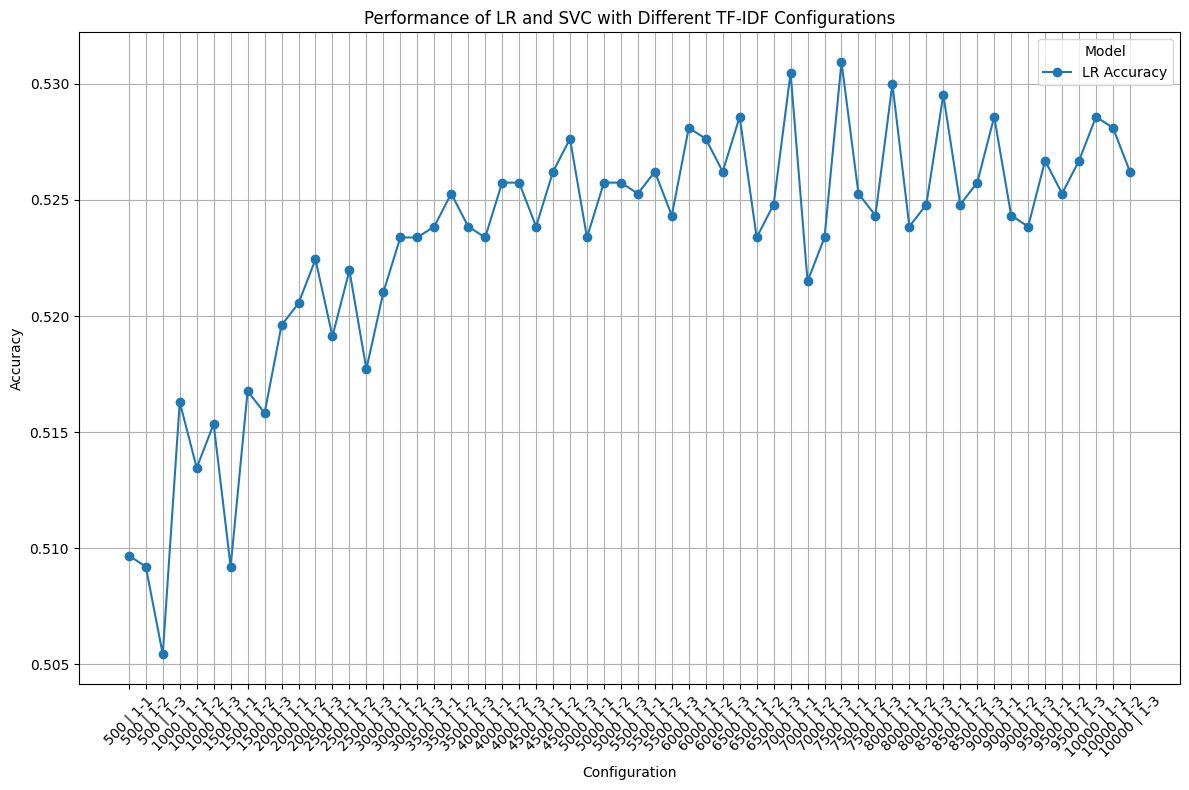

In [26]:
# Visualization with a line plot
fig, ax = plt.subplots(figsize=(12, 8))
tf_results_df.plot(kind='line', x='Config', y=['LR Accuracy'], marker='o', ax=ax)
ax.set_title('Performance of LR and SVC with Different TF-IDF Configurations')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Configuration')
plt.xticks(ticks=range(len(tf_results_df['Config'])), labels=tf_results_df['Config'], rotation=45)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Define the parameter grid
max_features_options = [1000, 3000, 5000]
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigrams, bigrams, and trigrams

# Store results
bow_results = []

# Iterate over each combination of parameters
for max_features in max_features_options:
    for ngram_range in ngram_ranges:
        vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=max_features, ngram_range=ngram_range)
        X = vectorizer.fit_transform(posts['tokens'])
        y = posts['link_flair_text']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Logistic Regression
        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(X_train, y_train)
        lr_predictions = lr_model.predict(X_test)
        lr_accuracy = accuracy_score(y_test, lr_predictions)

        # Train SVM
        svc_model = SVC()
        svc_model.fit(X_train, y_train)
        svc_predictions = svc_model.predict(X_test)
        svc_accuracy = accuracy_score(y_test, svc_predictions)

        # Append results
        bow_results.append({
            'Max Features': max_features,
            'Ngram Range': ngram_range,
            'LR Accuracy': lr_accuracy,
            'SVC Accuracy': svc_accuracy
        })

# Convert results to DataFrame
bow_results_df = pd.DataFrame(bow_results)

# Create a new column for easier plotting
bow_results_df['Config'] = bow_results_df['Max Features'].astype(str) + ' | ' + bow_results_df['Ngram Range'].apply(lambda x: f"{x[0]}-{x[1]}")

print(bow_results_df)

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: Th

   Max Features Ngram Range  LR Accuracy  SVC Accuracy      Config

0          1000      (1, 1)     0.459613      0.509684  1000 | 1-1

1          1000      (1, 2)     0.459140      0.503070  1000 | 1-2

2          1000      (1, 3)     0.461030      0.502598  1000 | 1-3

3          3000      (1, 1)     0.481342      0.513462  3000 | 1-1

4          3000      (1, 2)     0.487010      0.507794  3000 | 1-2

5          3000      (1, 3)     0.486538      0.509684  3000 | 1-3

6          5000      (1, 1)     0.488899      0.512518  5000 | 1-1

7          5000      (1, 2)     0.491261      0.507794  5000 | 1-2

8          5000      (1, 3)     0.495513      0.506377  5000 | 1-3


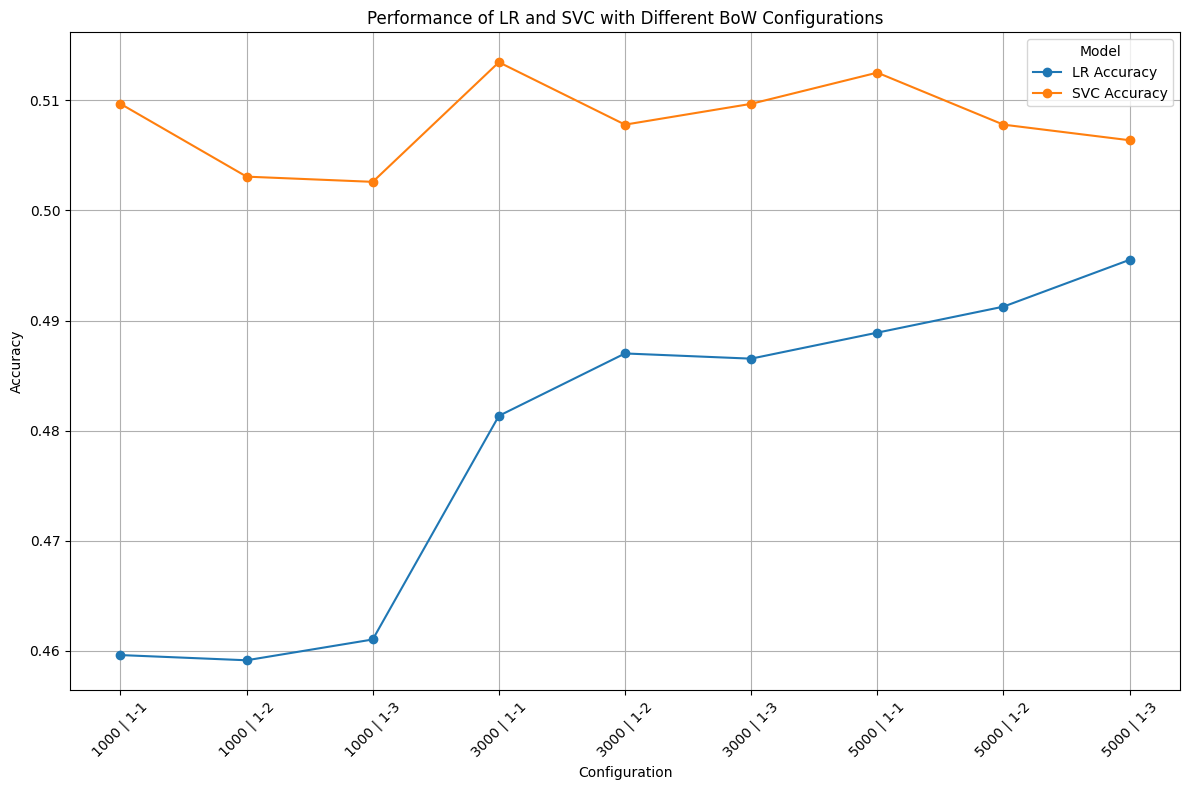

In [14]:
# Visualization with a line plot
fig, ax = plt.subplots(figsize=(12, 8))
bow_results_df.plot(kind='line', x='Config', y=['LR Accuracy', 'SVC Accuracy'], marker='o', ax=ax)
ax.set_title('Performance of LR and SVC with Different BoW Configurations')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Configuration')
plt.xticks(ticks=range(len(bow_results_df['Config'])), labels=bow_results_df['Config'], rotation=45)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



    Window Size  Vector Size  Min Count                Model   Accuracy

0             2          100          1  Logistic Regression  47.283892

1             2          100          1                  SVC  48.937175

2             2          100          2  Logistic Regression  47.142182

3             2          100          2                  SVC  49.362305

4             2          100          5  Logistic Regression  46.811526

5             2          100          5                  SVC  49.740198

6             2          200          1  Logistic Regression  47.047709

7             2          200          1                  SVC  48.512045

8             2          200          2  Logistic Regression  47.189419

9             2          200          2                  SVC  48.323099

10            2          200          5  Logistic Regression  47.661786

11            2          200          5                  SVC  48.370335

12            2          300          1  Logistic R

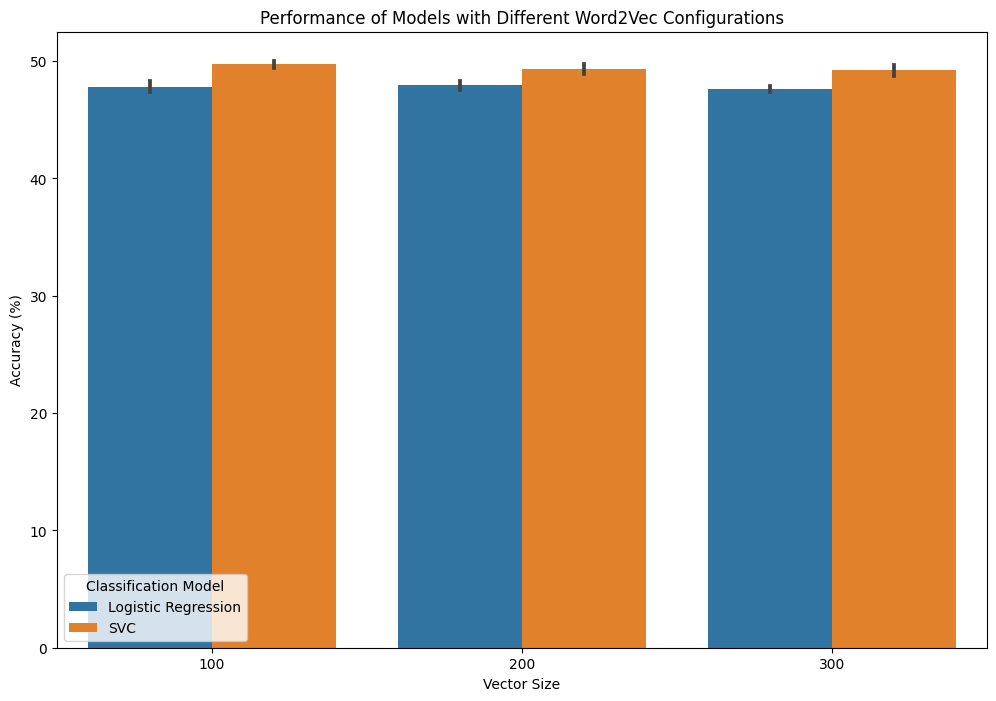

In [14]:
# Define the parameter grid
window_sizes = [2, 5, 10]
vector_sizes = [100, 200, 300]
min_counts = [1, 2, 5]

# Store results
w2v_results = []

# Function to generate vectors from a Word2Vec model
def vectorize(tokens_list, model):
    features = []
    for tokens in tokens_list:
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if vectors:
            vectors = np.array(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

# Iterate over each combination of parameters
for i in range(5, 30):
    for size in vector_sizes:
        for min_count in min_counts:
            model = Word2Vec(sentences=posts['tokens'], window=window, vector_size=size, min_count=min_count, workers=4, seed=42)
            vectors = vectorize(posts['tokens'], model)
            
            X_train, X_test, y_train, y_test = train_test_split(vectors, posts['link_flair_text'], test_size=0.2, random_state=42)

            # Logistic Regression
            lr_pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=1000))
            ])
            lr_pipeline.fit(X_train, y_train)
            lr_pred = lr_pipeline.predict(X_test)
            lr_accuracy = accuracy_score(y_test, lr_pred)

            # SVM
            svc_pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('svc', SVC())
            ])
            svc_pipeline.fit(X_train, y_train)
            svc_pred = svc_pipeline.predict(X_test)
            svc_accuracy = accuracy_score(y_test, svc_pred)

            # Store results
            w2v_results.append({
                'Window Size': window,
                'Vector Size': size,
                'Min Count': min_count,
                'Model': 'Logistic Regression',
                'Accuracy': lr_accuracy * 100
            })
            w2v_results.append({
                'Window Size': window,
                'Vector Size': size,
                'Min Count': min_count,
                'Model': 'SVC',
                'Accuracy': svc_accuracy * 100
            })

# Convert results to DataFrame and display
w2v_results_df = pd.DataFrame(w2v_results)
print(w2v_results_df)

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=w2v_results_df, x='Vector Size', y='Accuracy', hue='Model')
ax.set_title('Performance of Models with Different Word2Vec Configurations')
ax.set_xlabel('Vector Size')
ax.set_ylabel('Accuracy (%)')
plt.legend(title='Classification Model')
plt.show()

In [22]:
def objective(trial):
    # Define the hyperparameters to tune via Optuna
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    max_features = trial.suggest_int('max_features', 1000, 5000, step=1000)
    classifier_type = trial.suggest_categorical('classifier_type', ['LogisticRegression'])
    
    # Set up the vectorizer
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=max_features, ngram_range=ngram_range)
    X = vectorizer.fit_transform(posts['tokens'])
    y = posts['link_flair_text']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Set up the classifier
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    model = LogisticRegression(max_iter=1000, C=C)
    
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return 1 - accuracy  # Optuna tries to minimize the objective

# Create a study object
study = optuna.create_study()
study.optimize(objective, n_trials=50)  # You can increase n_trials for a more thorough search

print("Best parameters: ", study.best_params)
print("Best cross-validation accuracy: ", 1 - study.best_value)

[I 2024-05-07 20:03:19,399] A new study created in memory with name: no-name-225f6a17-e009-4054-8b10-f5faca8c9ded

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.

  warnings.warn(message)

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.

  warnings.warn(message)

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.

  warnings.warn(message

Best parameters:  {'ngram_range': (1, 2), 'max_features': 8500, 'classifier_type': 'LogisticRegression', 'C': 0.03979139050308575}

Best cross-validation accuracy:  0.5219650448748229


In [23]:
def objective(trial):
    # Define the hyperparameters to tune via Optuna
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    max_features = trial.suggest_int('max_features', 500, 10000, step=500)
    classifier_type = trial.suggest_categorical('classifier_type', ['SVC'])
    
    # Set up the vectorizer
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=max_features, ngram_range=ngram_range)
    X = vectorizer.fit_transform(posts['tokens'])
    y = posts['link_flair_text']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
    model = SVC(C=C, gamma=gamma)

    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return 1 - accuracy  # Optuna tries to minimize the objective

# Create a study object
study = optuna.create_study()
study.optimize(objective, n_trials=50)  # You can increase n_trials for a more thorough search

print("Best parameters: ", study.best_params)
print("Best cross-validation accuracy: ", 1 - study.best_value)

[I 2024-05-07 20:07:35,664] A new study created in memory with name: no-name-a28af485-939d-460b-9e5d-fc3e018629d1

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.

  warnings.warn(message)

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.

  warnings.warn(message)

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.

  warnings.warn(message

Best parameters:  {'ngram_range': (1, 1), 'max_features': 8500, 'classifier_type': 'SVC', 'C': 14.809641072844258, 'gamma': 0.0012191969903141962}

Best cross-validation accuracy:  0.5238545111006141


In [25]:
def objective(trial):
    # Define the hyperparameters to tune via Optuna
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    max_features = trial.suggest_int('max_features', 500, 10000, step=500)
    classifier_type = trial.suggest_categorical('classifier_type', ['LogisticRegression'])
    
    # Set up the vectorizer
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=max_features, ngram_range=ngram_range)
    X = vectorizer.fit_transform(posts['tokens'])
    y = posts['link_flair_text']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Set up the classifier
    if classifier_type == 'LogisticRegression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        model = LogisticRegression(max_iter=1000, C=C)
    else:
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
        model = SVC(C=C, gamma=gamma)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return 1 - accuracy  # Optuna tries to minimize the objective

# Create a study object
study = optuna.create_study()
study.optimize(objective, n_trials=50)  # You can increase n_trials for a more thorough search

print("Best parameters: ", study.best_params)
print("Best cross-validation accuracy: ", 1 - study.best_value)

[I 2024-05-08 00:20:34,463] A new study created in memory with name: no-name-7eae3006-46fb-4358-9409-a91ab06c25d1

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.

  warnings.warn(message)

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.

  warnings.warn(message)

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.

  warnings.warn(message)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: User

Best parameters:  {'ngram_range': (1, 2), 'max_features': 4000, 'classifier_type': 'LogisticRegression', 'C': 0.023094958480987273}

Best cross-validation accuracy:  0.5172413793103449


In [15]:
tf_results = []

for i in range(500, 10001, 500):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=i)
    X = vectorizer.fit_transform(posts['tokens'])  # Assuming posts['tokens'] exists
    y = posts['link_flair_text']  # Assuming posts['link_flair_text'] exists

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    
    svc_model = SVC()
    svc_model.fit(X_train, y_train)
    svc_predictions = svc_model.predict(X_test)
    svc_accuracy = accuracy_score(y_test, svc_predictions)

    tf_results.append({
        'Max Features': i,
        'LR Accuracy': lr_accuracy,
        'SVC Accuracy': svc_accuracy
    })

tf_results_df = pd.DataFrame(tf_results)

print(tf_results_df[tf_results_df['LR Accuracy'] == tf_results_df['LR Accuracy'].max()])
print(tf_results_df[tf_results_df['SVC Accuracy'] == tf_results_df['SVC Accuracy'].max()])

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: Th

    Max Features  LR Accuracy  SVC Accuracy

14          7500      0.53094      0.523382

   Max Features  LR Accuracy  SVC Accuracy

3          2000     0.519603      0.530468


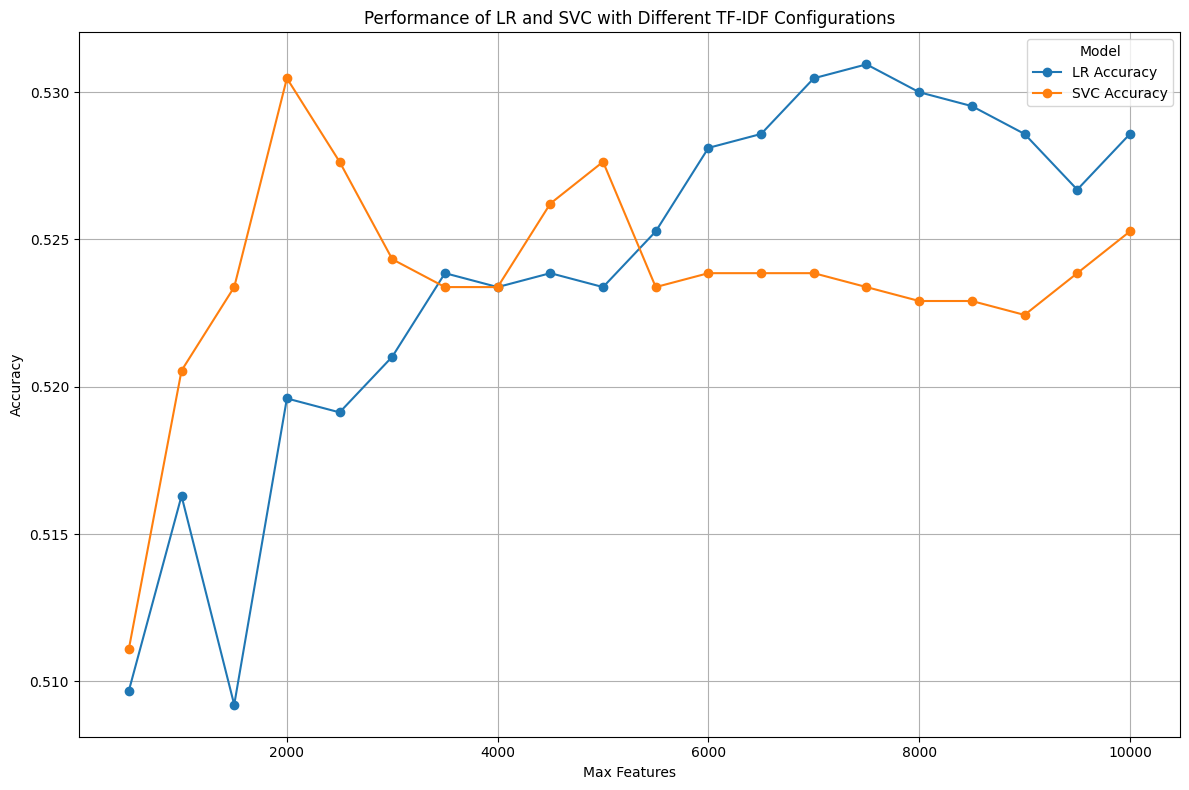

In [16]:
# Visualization with a line plot
fig, ax = plt.subplots(figsize=(12, 8))
tf_results_df.plot(kind='line', x='Max Features', y=['LR Accuracy', 'SVC Accuracy'], marker='o', ax=ax)
ax.set_title('Performance of LR and SVC with Different TF-IDF Configurations')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Max Features')
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
bow_results = []

for i in range(500, 10001, 500):
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=i)
    X = vectorizer.fit_transform(posts['tokens'])  # Assuming posts['tokens'] exists
    y = posts['link_flair_text']  # Assuming posts['link_flair_text'] exists

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    
    svc_model = SVC()
    svc_model.fit(X_train, y_train)
    svc_predictions = svc_model.predict(X_test)
    svc_accuracy = accuracy_score(y_test, svc_predictions)

    bow_results.append({
        'Max Features': i,
        'LR Accuracy': lr_accuracy,
        'SVC Accuracy': svc_accuracy
    })

bow_results_df = pd.DataFrame(bow_results)

print(bow_results_df[bow_results_df['LR Accuracy'] == bow_results_df['LR Accuracy'].max()])
print(bow_results_df[bow_results_df['SVC Accuracy'] == bow_results_df['SVC Accuracy'].max()])

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(

/Users/cadejeong/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: Th

    Max Features  LR Accuracy  SVC Accuracy

18          9500     0.495985       0.51299

   Max Features  LR Accuracy  SVC Accuracy

6          3500     0.479924       0.51488


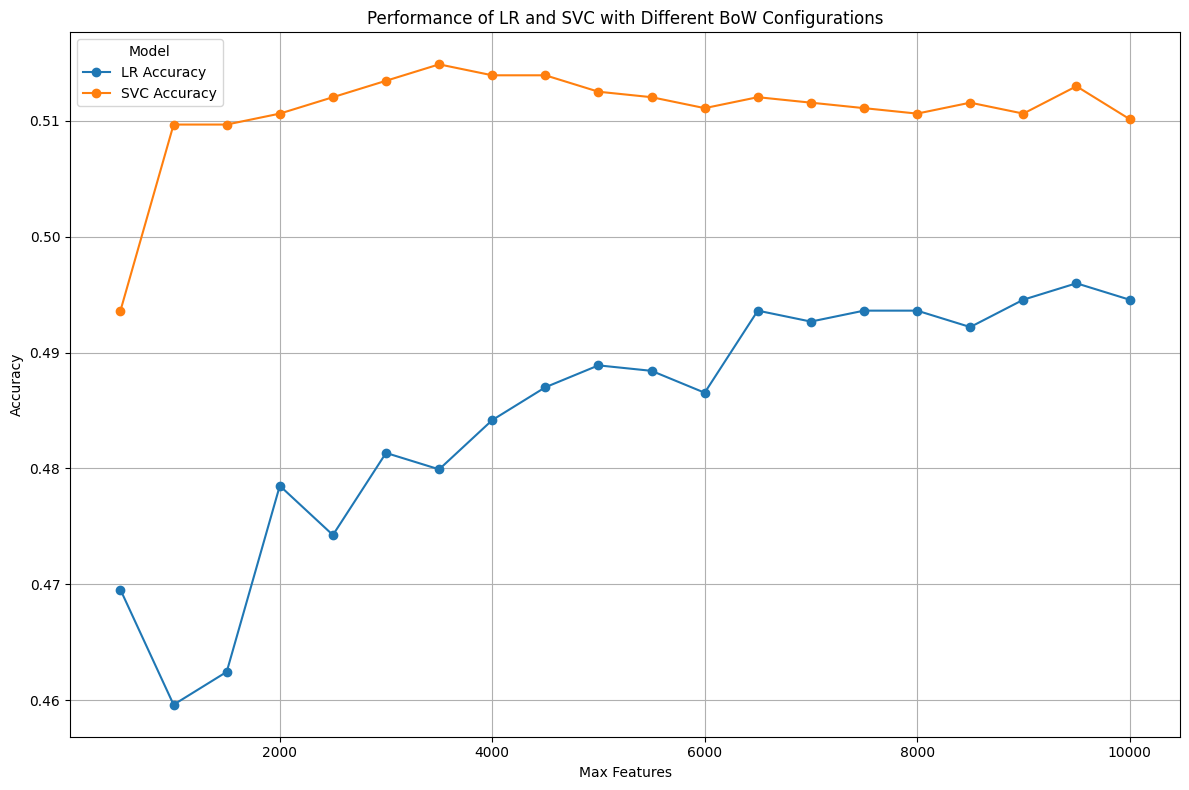

In [19]:
# Visualization with a line plot
fig, ax = plt.subplots(figsize=(12, 8))
bow_results_df.plot(kind='line', x='Max Features', y=['LR Accuracy', 'SVC Accuracy'], marker='o', ax=ax)
ax.set_title('Performance of LR and SVC with Different BoW Configurations')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Max Features')
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Store results
w2v_results = []

# Function to generate vectors from a Word2Vec model
def vectorize(tokens_list, model):
    features = []
    for tokens in tokens_list:
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if vectors:
            vectors = np.array(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

# Iterate over each combination of parameters
for i in range(5, 30, 5):
    for j in range(100, 1000, 100):
        for k in range(1, 14, 2):
            model = Word2Vec(sentences=posts['tokens'], window=i, vector_size=j, workers=k, seed=42)
            vectors = vectorize(posts['tokens'], model)
            
            X_train, X_test, y_train, y_test = train_test_split(vectors, posts['link_flair_text'], test_size=0.2, random_state=42)

            # Logistic Regression
            lr_pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=1000))
            ])
            lr_pipeline.fit(X_train, y_train)
            lr_pred = lr_pipeline.predict(X_test)
            lr_accuracy = accuracy_score(y_test, lr_pred)

            # SVM
            svc_pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('svc', SVC())
            ])
            svc_pipeline.fit(X_train, y_train)
            svc_pred = svc_pipeline.predict(X_test)
            svc_accuracy = accuracy_score(y_test, svc_pred)

            # Store results
            w2v_results.append({
                'Window Size': i,
                'Vector Size': j,
                'Workers': k,
                'Model': 'Logistic Regression',
                'LR Accuracy': lr_accuracy * 100
            })
            w2v_results.append({
                'Window Size': i,
                'Vector Size': j,
                'Worekrs': k,
                'Model': 'SVC',
                'SVC Accuracy': svc_accuracy * 100
            })

# Convert results to DataFrame and display
w2v_results_df = pd.DataFrame(w2v_results)

w2v_results_df['Configuration'] = w2v_results_df.apply(lambda x: f'W:{x["Window Size"]} V:{x["Vector Size"]} W:{x["Workers"]}', axis=1)

print(w2v_results_df[w2v_results_df['LR Accuracy'] == w2v_results_df['LR Accuracy'].max()])
print(w2v_results_df[w2v_results_df['SVC Accuracy'] == w2v_results_df['SVC Accuracy'].max()])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

KeyError: 'LR Accuracy'

In [13]:
print(w2v_results_df)

     Window Size  Vector Size  Min Count                Model   Accuracy  \
0              5          100          1  Logistic Regression  47.614549   
1              5          100          1                  SVC  50.023618   
2              5          100          3  Logistic Regression  47.567312   
3              5          100          3                  SVC  49.787435   
4              5          100          5  Logistic Regression  47.331129   
..           ...          ...        ...                  ...        ...   
625           25          900          9                  SVC  50.543222   
626           25          900         11  Logistic Regression  48.984412   
627           25          900         11                  SVC  50.684932   
628           25          900         13  Logistic Regression  48.889939   
629           25          900         13                  SVC  50.354275   

       Configuration  
0      W:5 V:100 M:1  
1      W:5 V:100 M:1  
2      W:5 V:100 M

In [17]:
# Rename 'Min Count' to 'Workers'
w2v_results_df.rename(columns={"Min Count": "Workers"}, inplace=True)

# Change 'M' in configuration to 'W'
w2v_results_df['Configuration'] = w2v_results_df['Configuration'].str.replace(' M:', ' W:')

# Corrected approach to retrieve the best rows for each model type
best_lr = w2v_results_df[w2v_results_df['Model'] == "Logistic Regression"].loc[w2v_results_df[w2v_results_df['Model'] == "Logistic Regression"]['Accuracy'].idxmax()]
best_svc = w2v_results_df[w2v_results_df['Model'] == "SVC"].loc[w2v_results_df[w2v_results_df['Model'] == "SVC"]['Accuracy'].idxmax()]

best_lr, best_svc

(Window Size                       20
 Vector Size                      500
 Workers                           11
 Model            Logistic Regression
 Accuracy                   49.362305
 Configuration        W:20 V:500 W:11
 Name: 444, dtype: object,
 Window Size                  25
 Vector Size                 200
 Workers                       9
 Model                       SVC
 Accuracy              51.629665
 Configuration    W:25 V:200 W:9
 Name: 527, dtype: object)

In [19]:
# Plotting the results as a line plot
fig, ax = plt.subplots(figsize=(14, 8))  # Increased figure size for better legibility
sns.lineplot(data=w2v_results_df, x='Configuration', y='Accuracy', hue='Model', style='Model', markers=True, dashes=False)
ax.set_title('Performance of Models with Different Word2Vec Configurations')
ax.set_xlabel('Configuration')
ax.set_ylabel('Accuracy (%)')
plt.legend(title='Classification Model')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


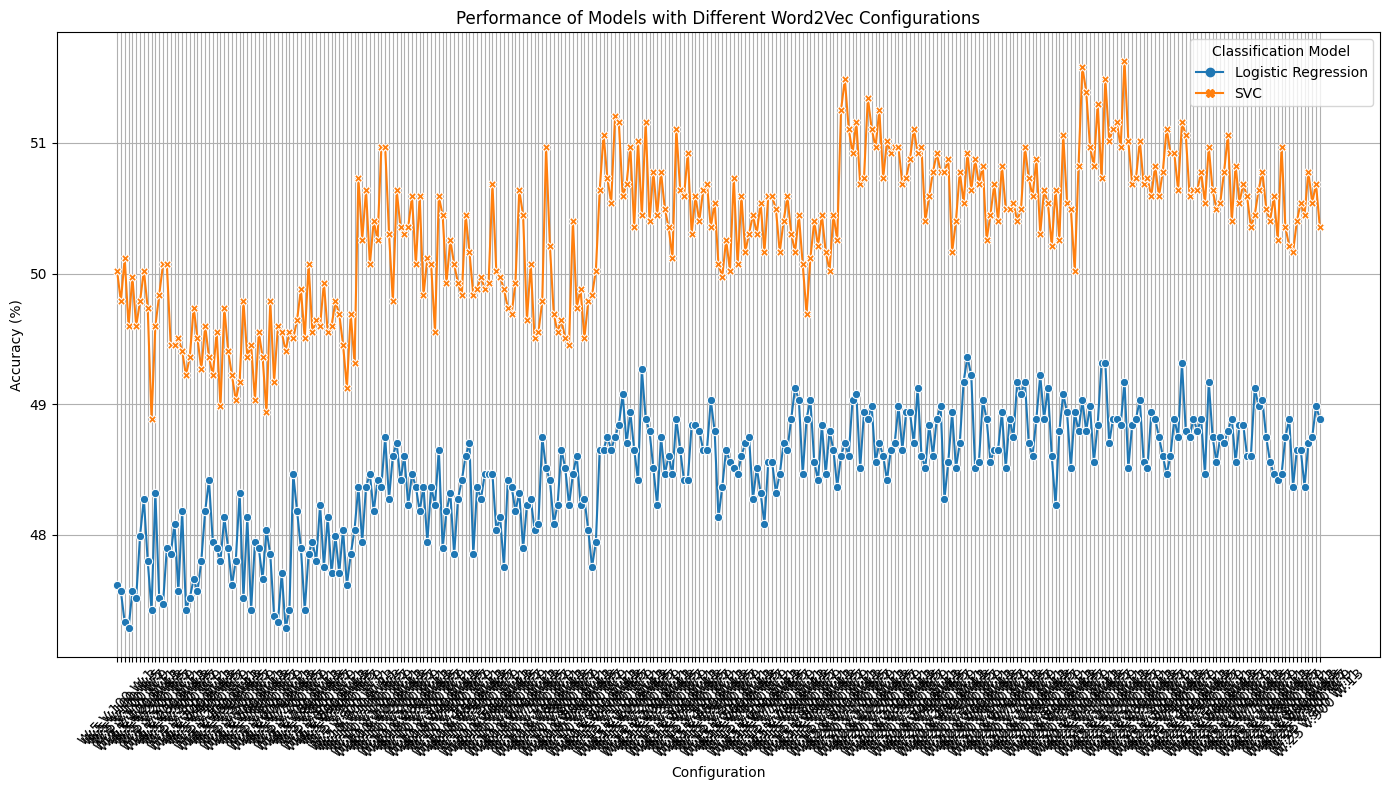

In [20]:
# Plotting the results as a line plot
fig, ax = plt.subplots(figsize=(14, 8))  # Increased figure size for better legibility
sns.lineplot(data=w2v_results_df, x='Configuration', y='Accuracy', hue='Model', style='Model', markers=True, dashes=False)
ax.set_title('Performance of Models with Different Word2Vec Configurations')
ax.set_xlabel('Configuration')
ax.set_ylabel('Accuracy (%)')
plt.legend(title='Classification Model')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


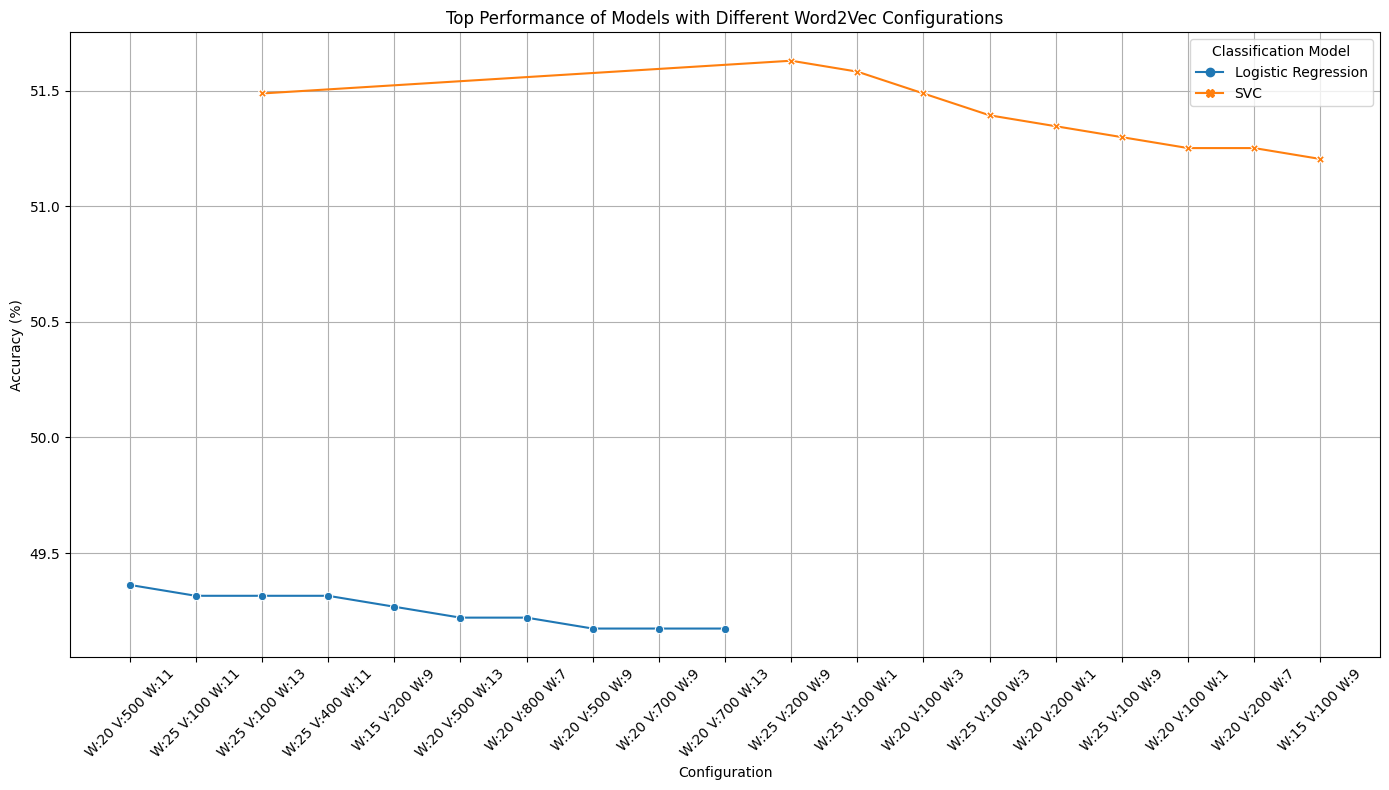

In [21]:
# Sorting and selecting top configurations based on accuracy
top_lr = w2v_results_df[w2v_results_df['Model'] == 'Logistic Regression'].nlargest(10, 'Accuracy')
top_svc = w2v_results_df[w2v_results_df['Model'] == 'SVC'].nlargest(10, 'Accuracy')

# Combining the results back for plotting
top_results_df = pd.concat([top_lr, top_svc])

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=top_results_df, x='Configuration', y='Accuracy', hue='Model', style='Model', markers=True, dashes=False)
ax.set_title('Top Performance of Models with Different Word2Vec Configurations')
ax.set_xlabel('Configuration')
ax.set_ylabel('Accuracy (%)')
plt.legend(title='Classification Model')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()